# Домашнее задание №6
**Анализ учебного синтетического датасета**

Ноутбук HW06.ipynb содержит:
- загрузка выбранного S06-hw-dataset-0X.csv;
- базовый EDA и анализ баланса классов;
- train/test-сплит с random_state и stratify;
- baseline: Dummy + LogisticRegression;
- минимум 3 модели недели 6 (дерево + лес + boosting), с подбором параметров на train через CV;
- честная финальная оценка на test по согласованным метрикам;
- интерпретация лучшей модели (permutation importance) + текстовые выводы

## Импорт библиотек и датасета

In [41]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.pipeline import Pipeline

from sklearn.metrics import brier_score_loss, confusion_matrix, accuracy_score, classification_report, roc_auc_score, precision_score, recall_score, f1_score, roc_curve, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import PrecisionRecallDisplay, RocCurveDisplay

from sklearn.inspection import permutation_importance
import joblib
import json
import os
from datetime import datetime

In [2]:
RANDOM_STATE=42

In [3]:
def print_metrics(y_true, y_pred, y_proba=None, title=None):
    # Печатаем несколько полезных метрик для бинарной классификации.
    # ROC-AUC считаем только если есть вероятности/скор (y_proba).
    if title:
        print(f"=== {title} - качество на test ===")
    print("Classification Report: \n", classification_report(y_true, y_pred))
    if y_proba is not None:
        try:
            auc = roc_auc_score(y_true, y_proba)
            print(f"roc_auc  = {auc:.4f}")
        except Exception:
            # На случай, если y_proba по каким-то причинам некорректный (редко, но бывает)
            pass
    print("confusion_matrix:")
    print(confusion_matrix(y_true, y_pred))
    
    print()
    
def PR_ROC(dummy_clf, model, X_test, y_test, title="model"):
    classifiers = {f"{title}": model,
                   "baseline": dummy_clf}

    fig, [ax_roc, ax_pr] = plt.subplots(1, 2, figsize=(11, 5))
    
    ax_roc.set_title("ROC")
    ax_pr.set_title("PR")
    
    ax_roc.grid(linestyle="--")
    ax_pr.grid(linestyle="--")
    
    for name, clf in classifiers.items():
        (color, linestyle) = (
            ("black", "--") if name == "baseline" else (None, None)
        )
        RocCurveDisplay.from_estimator(
            clf,
            X_test,
            y_test,
            ax=ax_roc,
            name=name,
            curve_kwargs=dict(color=color, linestyle=linestyle),
        )
        PrecisionRecallDisplay.from_estimator(
            clf,
            X_test, 
            y_test, 
            ax=ax_pr,
            name=name, 
            color=color, linestyle=linestyle,
        )
    
    plt.savefig(f"artifacts/figures/rocandstonePR_{title}.png")
    plt.show()

In [4]:
df = pd.read_csv("S06-hw-dataset-04.csv")

## Описание датасета и базовый EDA

In [5]:
df.head()

,id,f01,f02,f03,f04,f05,f06,f07,f08,f09,...,f52,f53,f54,f55,f56,f57,f58,f59,f60,target
0,1,-1.250210,1.423474,-0.225004,-4.023138,-0.832729,-0.550874,1.772090,2.761690,-0.698750,...,10.938269,0.501178,1.600001,0.314212,1.209735,1.355697,-5.338924,1.153944,-0.153934,0
1,2,0.074328,0.376429,0.212831,-0.502074,2.017405,0.625496,1.943785,1.242030,-0.524090,...,7.775262,-4.550195,6.272586,-0.932162,-0.228543,1.735220,-3.827828,0.292165,0.273720,0
2,3,0.638481,0.060968,0.746760,2.479653,-0.292858,-0.078139,-2.918423,-0.013186,1.009135,...,-4.448447,-9.593179,-3.093519,0.029321,0.605511,0.829103,-0.085985,2.891408,0.766221,0
3,4,1.712916,-1.350969,-0.256473,1.622074,-0.445141,0.911932,-3.440345,1.505192,-1.104348,...,-1.619072,-3.237479,-5.474038,-1.582475,0.198137,3.823409,0.880395,1.148610,0.136732,0
4,5,0.905676,-0.206545,-0.068806,4.086026,-1.010045,-0.772644,-4.207688,2.506104,1.589143,...,-2.396844,-10.540129,-5.532811,-1.231203,0.000119,4.298572,-1.558235,0.924673,0.111668,0


In [73]:
df.shape

(25000, 61)

In [6]:
df.describe()

,id,f01,f02,f03,f04,f05,f06,f07,f08,f09,...,f52,f53,f54,f55,f56,f57,f58,f59,f60,target
count,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,...,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.00000
mean,12500.500000,-0.000386,-0.004872,0.003202,0.335329,-0.000563,-0.010118,0.001182,0.957385,-0.004658,...,-0.166251,-3.387506,1.749793,-0.013017,-0.001383,0.893365,-0.909479,0.000570,-0.000754,0.04920
std,7217.022701,1.001623,0.995606,1.004367,3.207537,0.993965,1.002172,2.432162,1.830223,1.013470,...,4.234741,4.331576,5.318660,1.001594,0.996409,2.445185,1.962618,0.994320,0.997167,0.21629
min,1.000000,-4.370993,-4.087073,-4.103875,-13.249937,-4.118778,-3.895974,-8.883224,-8.132548,-4.068933,...,-20.021141,-18.332290,-20.336666,-4.349216,-4.119472,-9.508509,-7.919287,-4.038312,-3.812255,0.00000
25%,6250.750000,-0.680165,-0.675100,-0.675426,-1.750048,-0.669764,-0.674374,-1.647977,-0.217260,-0.688278,...,-2.897904,-6.278403,-1.775889,-0.689962,-0.676191,-0.735473,-2.226959,-0.666367,-0.665861,0.00000
50%,12500.500000,0.001859,-0.000247,0.013272,0.403483,-0.001309,-0.005994,-0.011349,0.963009,0.000414,...,-0.396946,-3.462072,1.931851,-0.020933,-0.004193,0.888535,-0.923354,0.004381,0.002420,0.00000
75%,18750.250000,0.679702,0.659523,0.683437,2.486453,0.672299,0.652629,1.658680,2.167758,0.681040,...,2.344956,-0.578540,5.473886,0.661300,0.673722,2.516790,0.395648,0.666474,0.665918,0.00000
max,25000.000000,4.208888,3.984564,3.793442,15.288250,4.020733,4.279607,9.538525,9.321099,4.261349,...,20.717964,18.818764,20.688069,4.338337,3.902131,11.880651,6.778980,3.834922,4.012639,1.00000


In [7]:
print(f"Количество пропусков по колонкам: {df.isna().sum().sum()}") # их нет

Количество пропусков по колонкам: 0


In [8]:
print("Дубликаты: ") # их нет
df[df.duplicated()==True]

Дубликаты: 


,id,f01,f02,f03,f04,f05,f06,f07,f08,f09,...,f52,f53,f54,f55,f56,f57,f58,f59,f60,target


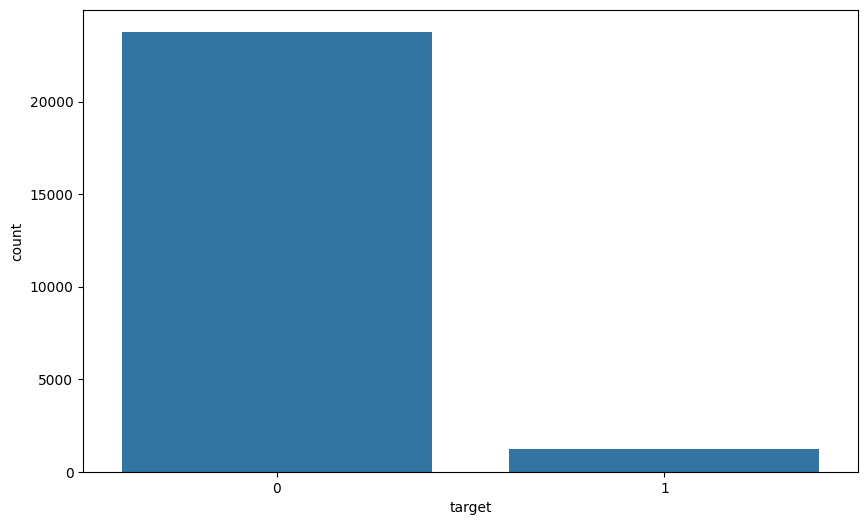

In [9]:
plt.figure(figsize=(10, 6))
sns.countplot(x = df['target']) 
plt.savefig("artifacts/figures/hist.png")
plt.show()

In [10]:
np.mean(df["target"])

np.float64(0.0492)

Наблюдаем огромный перекос в балансе классов в сторону нулей.

In [11]:
corr = df.corr()["target"]
corr.abs()[corr > 0.1] # действительно коррелирующих с таргетом колонок очень мало

f36       0.113409
f41       0.105467
f47       0.164823
f53       0.221280
f58       0.178578
target    1.000000
Name: target, dtype: float64

## Подготовка данных

In [12]:
df = df.drop("id", axis=1)

In [13]:
X = df.drop("target", axis=1)
y = df["target"]

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.33,
    stratify=y,
    random_state=RANDOM_STATE,
)

In [15]:
print(f"Размер выборки X_train: {X_train.shape}")
print(f"Размер выборки y_train: {y_train.shape}")

print(f"\nРазмер выборки X_test: {X_test.shape}")
print(f"Размер выборки y_test: {y_test.shape}")

print("\nРаспределение классов (train):")
print(y_train.value_counts(normalize=True))

print("\nРаспределение классов (test):")
print(y_test.value_counts(normalize=True))

Размер выборки X_train: (16750, 60)
Размер выборки y_train: (16750,)

Размер выборки X_test: (8250, 60)
Размер выборки y_test: (8250,)

Распределение классов (train):
target
0    0.950806
1    0.049194
Name: proportion, dtype: float64

Распределение классов (test):
target
0    0.950788
1    0.049212
Name: proportion, dtype: float64


## Обучение моделей

### Dummy classifier + Logreg - baseline модели

In [16]:
log_reg = LogisticRegression(
            l1_ratio=0, #instead of penalty="l2",
            C=1.0,
            solver="liblinear",
            random_state=RANDOM_STATE,
            )
dummy_clf = DummyClassifier(strategy="stratified", random_state=RANDOM_STATE,)

In [17]:
dummy_clf.fit(X_train, y_train)

log_reg.fit(X_train, y_train)

,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",42
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`multicl

In [18]:
dclf_pred = dummy_clf.predict(X_test)
dclf_proba = dummy_clf.predict_proba(X_test)[:,1]

logreg_pred = log_reg.predict(X_test)
logreg_proba = log_reg.predict_proba(X_test)[:,1]

In [19]:
print_metrics(y_test, dclf_pred, dclf_proba, title="Dummy Classifier")

=== Dummy Classifier - качество на test ===
Classification Report: 
               precision    recall  f1-score   support

           0       0.95      0.95      0.95      7844
           1       0.04      0.04      0.04       406

    accuracy                           0.91      8250
   macro avg       0.49      0.49      0.49      8250
weighted avg       0.91      0.91      0.91      8250

roc_auc  = 0.4946
confusion_matrix:
[[7469  375]
 [ 391   15]]



In [20]:
print_metrics(y_test, logreg_pred, logreg_proba, title="Logistic Regression")

=== Logistic Regression - качество на test ===
Classification Report: 
               precision    recall  f1-score   support

           0       0.96      1.00      0.98      7844
           1       0.92      0.27      0.41       406

    accuracy                           0.96      8250
   macro avg       0.94      0.63      0.70      8250
weighted avg       0.96      0.96      0.95      8250

roc_auc  = 0.8286
confusion_matrix:
[[7835    9]
 [ 298  108]]



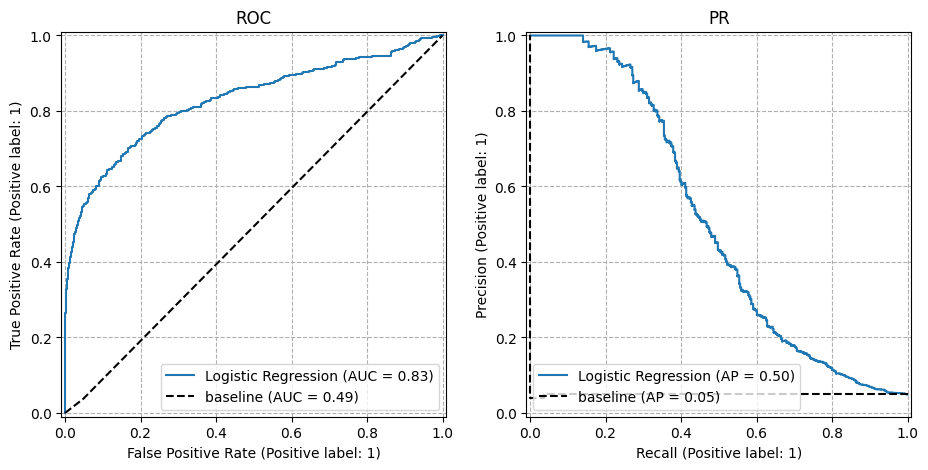

In [21]:
PR_ROC(dummy_clf, log_reg, X_test,  y_test, title="Logistic Regression")

## Основные модели: дерево решений, случайные леса, адабуст
### Дерево решений

In [22]:
dtree = DecisionTreeClassifier(random_state=RANDOM_STATE)

# Параметры для GridSearchCV
param_grid_dt = {
    'max_depth': [3, 5, 7, 10, 15, 20, 30],
    'min_samples_split': [10, 20],
    'min_samples_leaf': [4, 8],
}

# GridSearchCV для Decision Tree
grid_search_dt = GridSearchCV(
    estimator=dtree,
    param_grid=param_grid_dt,
    cv=5,  # можно увеличить до 10 для большей стабильности
    scoring='accuracy',
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

In [23]:
grid_search_dt.fit(X_train, y_train)

Fitting 5 folds for each of 28 candidates, totalling 140 fits


,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",DecisionTreeC...ndom_state=42)
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'max_depth': [3, 5, ...], 'min_samples_leaf': [4, 8], 'min_samples_split': [10, 20]}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'accuracy'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",5
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each fold and parameter candidate is displayed;- >2 : t

In [24]:
print(f"Лучшие параметры: {grid_search_dt.best_params_}")
print(f"Лучшая оценка: {grid_search_dt.best_score_:.4f}")

# Сохранение лучшей модели
best_dt_model = grid_search_dt.best_estimator_

Лучшие параметры: {'max_depth': 15, 'min_samples_leaf': 4, 'min_samples_split': 10}
Лучшая оценка: 0.9659


In [25]:
dtree_pred = best_dt_model.predict(X_test)
dtree_proba = best_dt_model.predict_proba(X_test)[:,1]

In [26]:
print_metrics(y_test, dtree_pred, dtree_proba, title="DTree")

=== DTree - качество на test ===
Classification Report: 
               precision    recall  f1-score   support

           0       0.97      0.99      0.98      7844
           1       0.71      0.46      0.56       406

    accuracy                           0.96      8250
   macro avg       0.84      0.73      0.77      8250
weighted avg       0.96      0.96      0.96      8250

roc_auc  = 0.7889
confusion_matrix:
[[7769   75]
 [ 219  187]]



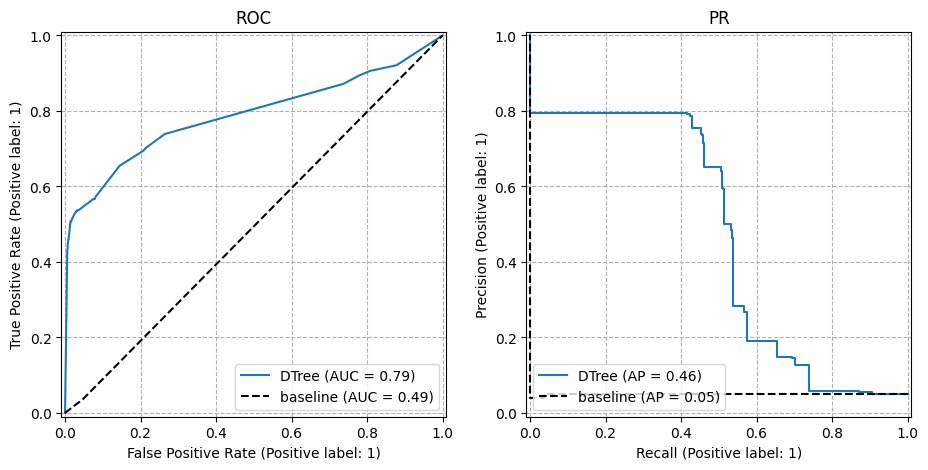

In [27]:
PR_ROC(dummy_clf, best_dt_model, X_test,  y_test, title="DTree")

### Случайные леса

In [29]:
rf = RandomForestClassifier(
    random_state=RANDOM_STATE,
    oob_score=True,
    n_jobs=-1,
)

param_grid = {
    "n_estimators":[300, 400, 600, 800],
}

rf_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

In [30]:
rf_search.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",RandomForestC...ndom_state=42)
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'n_estimators': [300, 400, ...]}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'roc_auc'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",5
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each fold and parameter candidate is displayed;- >2 : the score is also displayed;- >3 : the fold and candid

In [31]:
best_rf_model = rf_search.best_estimator_

print(f"Лучшие параметры: {rf_search.best_params_}")
print(f"Лучшая оценка (CV): {rf_search.best_score_:.4f}")
print(f"OOB score лучшей модели: {rf_search.best_estimator_.oob_score_:.4f}")

Лучшие параметры: {'n_estimators': 600}
Лучшая оценка (CV): 0.8857
OOB score лучшей модели: 0.9697


In [32]:
rf_pred = rf_search.best_estimator_.predict(X_test)
rf_proba = rf_search.best_estimator_.predict_proba(X_test)[:,1]

=== RF - качество на test ===
Classification Report: 
               precision    recall  f1-score   support

           0       0.97      1.00      0.99      7844
           1       0.99      0.42      0.59       406

    accuracy                           0.97      8250
   macro avg       0.98      0.71      0.79      8250
weighted avg       0.97      0.97      0.97      8250

roc_auc  = 0.8938
confusion_matrix:
[[7843    1]
 [ 234  172]]



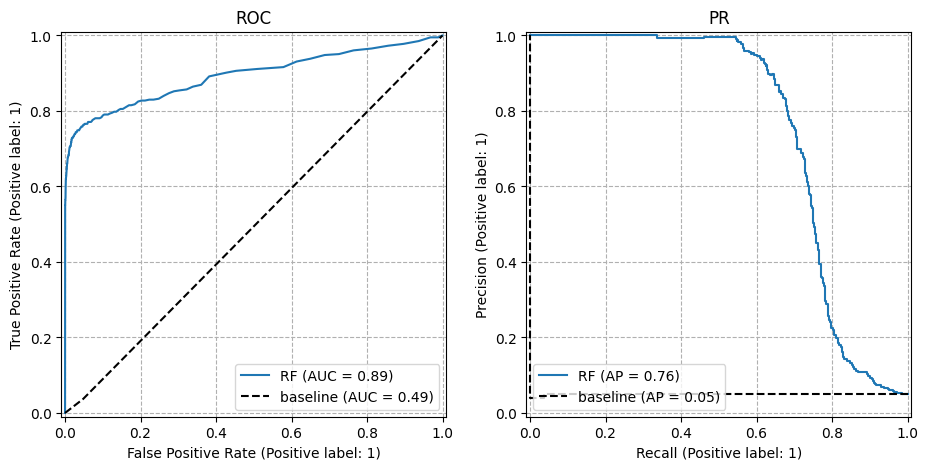

In [33]:
print_metrics(y_test, rf_pred, rf_proba, title="RF")
PR_ROC(dummy_clf, best_rf_model, X_test,  y_test, title="RF")

### Адабуст

In [36]:
# AdaBoost обычно демонстрируют с "пнями" – деревьями глубины 1:
# это слабая модель, но boosting умеет собирать из слабых моделей сильную.
stump = DecisionTreeClassifier(max_depth=1, random_state=RANDOM_STATE)

ada = AdaBoostClassifier(
    estimator=stump,
    random_state=RANDOM_STATE
)

param_grid_ada = {
        'estimator': [DecisionTreeClassifier(max_depth=1), 
                      DecisionTreeClassifier(max_depth=2)],
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.6],
                }


grid_search_ada = GridSearchCV(
    estimator=ada,
    param_grid=param_grid_ada,
    cv=5,
    scoring='roc_auc',  
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

In [37]:
# Запуск поиска
grid_search_ada.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",AdaBoostClass...ndom_state=42)
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'estimator': [DecisionTreeC...r(max_depth=1), DecisionTreeC...r(max_depth=2)], 'learning_rate': [0.6], 'n_estimators': [100, 200, ...]}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'roc_auc'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",5
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each 

In [38]:
# Результаты
print("AdaBoost - Результаты GridSearchCV")

print(f"Лучшие параметры: {grid_search_ada.best_params_}")
print(f"Лучшая оценка (CV): {grid_search_ada.best_score_:.4f}")
print(f"Лучшая модель: {grid_search_ada.best_estimator_}")

# Сохранение лучшей модели
best_ada_model = grid_search_ada.best_estimator_

# Детальный анализ результатов
results_df_ada = pd.DataFrame(grid_search_ada.cv_results_)
print("\nТоп-5 комбинаций параметров:")
top_results = results_df_ada.sort_values('mean_test_score', ascending=False).head()
print(top_results[['params', 'mean_test_score', 'std_test_score']])

AdaBoost - Результаты GridSearchCV
Лучшие параметры: {'estimator': DecisionTreeClassifier(max_depth=2), 'learning_rate': 0.6, 'n_estimators': 300}
Лучшая оценка (CV): 0.8863
Лучшая модель: AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=2),
                   learning_rate=0.6, n_estimators=300, random_state=42)

Топ-5 комбинаций параметров:
                                              params  mean_test_score  \
5  {'estimator': DecisionTreeClassifier(max_depth...         0.886305   
4  {'estimator': DecisionTreeClassifier(max_depth...         0.884484   
3  {'estimator': DecisionTreeClassifier(max_depth...         0.882500   
2  {'estimator': DecisionTreeClassifier(max_depth...         0.873099   
1  {'estimator': DecisionTreeClassifier(max_depth...         0.871112   

   std_test_score  
5        0.017583  
4        0.017140  
3        0.018251  
2        0.015433  
1        0.016676  


In [39]:
ada_pred = best_ada_model.predict(X_test)
ada_proba = best_ada_model.predict_proba(X_test)[:, 1]

=== ADA - качество на test ===
Classification Report: 
               precision    recall  f1-score   support

           0       0.97      1.00      0.98      7844
           1       0.94      0.42      0.58       406

    accuracy                           0.97      8250
   macro avg       0.96      0.71      0.78      8250
weighted avg       0.97      0.97      0.96      8250

roc_auc  = 0.8771
confusion_matrix:
[[7833   11]
 [ 234  172]]



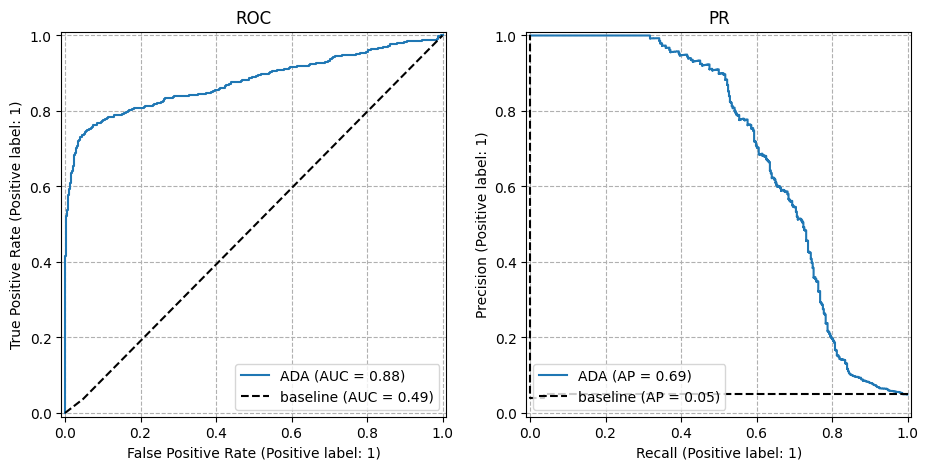

In [40]:
print_metrics(y_test, ada_pred, ada_proba, title="ADA")
PR_ROC(dummy_clf, best_ada_model, X_test,  y_test, title="ADA")

# Оценка моделей
Random Forest показал лучший результат по метрике ROC AUC. Сохраним модель и сделаем для нее Permutation Importance.

In [53]:
# Вычисляем permutation importance
print("\nВычисление Permutation Importance для лучшей модели")
perm = permutation_importance(
    best_rf_model, X_test, y_test,
    n_repeats=8,
    random_state=RANDOM_STATE,
    scoring="roc_auc"
)
pimp = perm.importances_mean
idx = np.argsort(pimp)[::-1][:12]


Вычисление Permutation Importance для лучшей модели


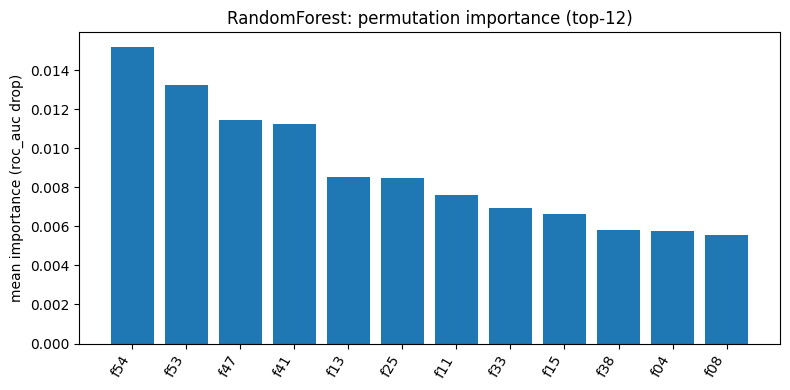

In [54]:
plt.figure(figsize=(8, 4))
plt.bar(range(len(idx)), pimp[idx])
plt.xticks(range(len(idx)), [df.columns[i] for i in idx], rotation=60, ha="right")
plt.ylabel("mean importance (roc_auc drop)")
plt.title("RandomForest: permutation importance (top-12)")
plt.tight_layout()
plt.show()

In [56]:
all_models = {
    'baseline': dummy_clf,
    'Logistic Regression': log_reg,
    'Decision Tree': grid_search_dt.best_estimator_,
    'Random Forest': rf_search.best_estimator_,
    'AdaBoost': grid_search_ada.best_estimator_
}

# Оцениваем все модели
results = {}

for model_name, model in all_models.items():
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None
    
    # Метрики
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    metrics = {
        'accuracy': float(accuracy),
        'precision': float(precision),
        'recall': float(recall),
        'f1': float(f1)
    }

    roc_auc = roc_auc_score(y_test, y_proba)
    metrics['roc_auc'] = float(roc_auc)
    
    # Сохраняем результаты
    results[model_name] = metrics

In [60]:
best_roc_auc = 0
for model_name, metrics in results.items():
    if metrics['roc_auc'] > best_roc_auc:
        best_roc_auc = metrics['roc_auc']
        best_model_name = model_name

In [62]:
best_roc_auc, best_model_name

(0.8937770201189198, 'Random Forest')

In [68]:
results

{'baseline': {'accuracy': 0.9071515151515152,
  'precision': 0.038461538461538464,
  'recall': 0.03694581280788178,
  'f1': 0.03768844221105527,
  'roc_auc': 0.49456928580220705},
 'Logistic Regression': {'accuracy': 0.9627878787878787,
  'precision': 0.9230769230769231,
  'recall': 0.2660098522167488,
  'f1': 0.4130019120458891,
  'roc_auc': 0.8285960465531058},
 'Decision Tree': {'accuracy': 0.9643636363636363,
  'precision': 0.7137404580152672,
  'recall': 0.4605911330049261,
  'f1': 0.5598802395209581,
  'roc_auc': 0.7888750587189103},
 'Random Forest': {'accuracy': 0.9715151515151516,
  'precision': 0.9942196531791907,
  'recall': 0.4236453201970443,
  'f1': 0.5941278065630398,
  'roc_auc': 0.8937770201189198},
 'AdaBoost': {'accuracy': 0.9703030303030303,
  'precision': 0.9398907103825137,
  'recall': 0.4236453201970443,
  'f1': 0.5840407470288624,
  'roc_auc': 0.8770743161601978}}

In [64]:
# 1. Сохраняем метрики на тесте
metrics_file = "artifacts/metrics_test.json"
with open(metrics_file, 'w') as f:
    json.dump(results, f, indent=2, default=str)
print(f"Метрики сохранены в {metrics_file}")

Метрики сохранены в artifacts/metrics_test.json


In [72]:
best_model = best_rf_model

# 2. Сохраняем информацию о лучших параметрах
search_summaries = {
    'DecisionTree': {
        'best_params': grid_search_dt.best_params_,
        'best_cv_score': float(grid_search_dt.best_score_)
    },
    'RandomForest': {
        'best_params': rf_search.best_params_,
        'best_cv_score': float(rf_search.best_score_)
    },
    'AdaBoost': {
        'best_params': grid_search_ada.best_params_,
        'best_cv_score': float(grid_search_ada.best_score_)
    }
}

search_file = "artifacts/search_summaries.json"
with open(search_file, 'w') as f:
    json.dump(search_summaries, f, indent=2, default=str)
print(f"Информация о поиске сохранена в {search_file}")

# 3. Сохраняем лучшую модель
best_model_file = "artifacts/best_model.joblib"
joblib.dump(best_model, best_model_file)
print(f"Лучшая модель сохранена в {best_model_file}")

# 4. Сохраняем метаданные лучшей модели
best_model_meta = {
    'model_name': best_model_name,
    'best_params': str(best_model.get_params()) if hasattr(best_model, 'get_params') else 'N/A',
    'test_metrics': results[best_model_name],
    'timestamp': datetime.now().isoformat(),
    'feature_importances': [df.columns[i] for i in idx]
}

meta_file = "artifacts/best_model_meta.json"
with open(meta_file, 'w') as f:
    json.dump(best_model_meta, f, indent=2, default=str)
print(f"Метаданные модели сохранены в {meta_file}")

Информация о поиске сохранена в artifacts/search_summaries.json
Лучшая модель сохранена в artifacts/best_model.joblib
Метаданные модели сохранены в artifacts/best_model_meta.json


## Выводы (см. report.md)

- Устойчивость: что будет, если поменять `random_state`? Метрики будут оставаться стабильными, хоть и будут наблюдаться небольшие колебания.
- Ошибки: confusion matrix для лучшей модели содержит основную часть ошибок в False Negative, False Positive при этом содержит минимум. Модель не переобучена. 
- Интерпретация permutation importance (top-12): наибольший вклад дают несколько ключевых числовых признаков, нет одного доминирующего. Остальные вносят крайне малый вклад.

Accuracy не подходит как основная метрика при дисбалансе. ROC-AUC — наиболее честный критерий сравнения моделей. Одиночные деревья склонны к переобучению. 

Ансамбли (RF, AdaBoost) значительно улучшают качество. 

Валидация только на train критична для честной оценки. Интерпретация через permutation importance остаётся возможной даже для ансамблей